# 模型选择、欠拟合和过拟合

## 多项式回归

In [1]:
import math
import numpy as np 
import torch
from torch import nn
from d2l import torch as d2l

### 1. 生成数据集

In [2]:
max_degree = 20 #多项式的最大阶数
n_train, n_test = 100, 100  #训练和测试数据集的大小
true_w = np.zeros(max_degree)   #分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)    #gamma(n) = (n - 1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) 
                for x in [true_w, features, poly_features, labels]]

### 2. 对模型进行训练和测试

首先让我们实现一个函数来评估模型在给定数据集上的损失。

In [4]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2) # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(),y.numel())
    return metric[0] / metric[1]


定义训练函数

In [5]:
from train import train_epoch
def poly_train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)), batch_size, is_train=True)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)), batch_size, is_train=False)

    optim = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch(net, train_iter, loss, optim)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))

    print('weight', net[0].weight.data.numpy())

### 3. 三阶多项式函数拟合(正常)

我们将首先使用三阶多项式函数，它与数据生成函数的阶数相同。 结果表明，该模型能有效降低训练损失和测试损失。 学习到的模型参数也接近真实值

weight [[ 4.9916396  1.4589739 -3.2651966  4.831248 ]]


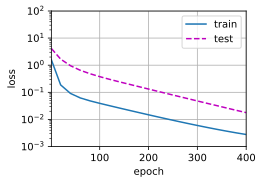

In [6]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
poly_train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

### 4. 线性函数拟合(欠拟合)

weight [[3.977836  2.5208285]]


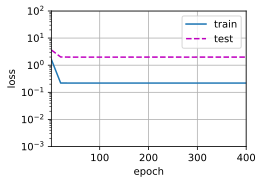

In [7]:
# 从多项式特征中选择前2个维度，即1和x
poly_train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

### 5. 高阶多项式函数拟合(过拟合)

weight [[ 5.018627    1.2197497  -3.402709    5.4374485  -0.22652678  0.9764638
   0.21706009 -0.02026484 -0.14416553 -0.13056622 -0.09830067 -0.13832952
   0.0388721   0.15938434  0.02223231 -0.00638989 -0.02681555 -0.02106816
  -0.00894338 -0.06390218]]


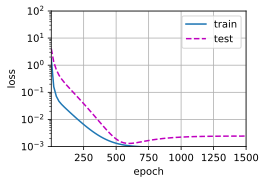

In [8]:
# 从多项式特征中选取所有维度
poly_train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)